# Visual-language assistant with LLaVA Next and OpenVINO

[LLaVA-NeXT](https://llava-vl.github.io/blog/2024-01-30-llava-next/) is new generation of LLaVA model family that marks breakthrough in advanced language reasoning over images, introducing improved OCR and expanded world knowledge. [LLaVA](https://llava-vl.github.io) (Large Language and Vision Assistant) is large multimodal model that aims to develop a general-purpose visual assistant that can follow both language and image instructions to complete various real-world tasks. The idea is to combine the power of large language models (LLMs) with vision encoders like CLIP to create an end-to-end trained neural assistant that understands and acts upon multimodal instructions.

In this tutorial we consider how to convert and optimize LLaVA-NeXT model from Transformers library for creating multimodal chatbot. We will utilize the power of [llava-v1.6-mistral-7b](https://huggingface.co/llava-hf/llava-v1.6-mistral-7b-hf) model for creating multimodal chatbot, but the similar actions are also applicable to other models of LLaVA family compatible with HuggingFace transformers implementation. Additionally, we demonstrate how to apply stateful transformation on LLM part and model optimization techniques like weights compression and quantization using [NNCF](https://github.com/openvinotoolkit/nncf) 

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Download PyTorch model](#Download-PyTorch-model)
- [Convert model to OpenVINO Intermediate Representation](#Convert-model-to-OpenVINO-Intermediate-Representation)
    - [Image Encoder](#Image-Encoder)
    - [Text Embedding](#Text-Embedding)
    - [Language Model](#Language-Model)
- [Compress Language Model Weights to 4 bits](#Compress-Language-Model-Weights-to-4-bits)
- [Quantize Image Encoder to 8 bits](#Quantize-Image-Encoder-to-8-bits)
    - [Prepare datasets](#Prepare-datasets)
    - [Perform quantization](#Perform-quantization)
- [Prepare model inference pipeline](#Prepare-model-inference-pipeline)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
    - [Select device](#Select-device)
- [Interactive demo](#Interactive-demo)



## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "openvino>=2024.0.0" "nncf>=2.9.0" "torch>=2.1" "transformers>=4.39.1" "accelerate" "pillow" "gradio" "datasets" "tqdm" --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
from pathlib import Path

MODEL_DIR = Path("model")
IMAGE_ENCODER_PATH = MODEL_DIR / "image_encoder.xml"
INPUT_EMBEDDING_PATH = MODEL_DIR / "input_embeddings.xml"
LANGUAGE_MODEL_PATH = MODEL_DIR / "language_model.xml"

requires_pt_model_loading = not all(
    [
        p.exists()
        for p in [IMAGE_ENCODER_PATH, INPUT_EMBEDDING_PATH, LANGUAGE_MODEL_PATH]
    ]
)

## Download PyTorch model
[back to top ⬆️](#Table-of-contents:)

In [3]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
import gc

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
image_encoder_model, input_embedding_model, language_model = None, None, None


class ImageEncoder(torch.nn.Module):
    def __init__(self, config, vision_tower, multi_modal_projector):
        super().__init__()
        self.config = config
        self.vision_tower = vision_tower
        self.multi_modal_projector = multi_modal_projector

    def forward(self, pixel_values):
        batch_size, num_patches, num_channels, height, width = pixel_values.shape
        reshaped_pixel_values = pixel_values.view(
            batch_size * num_patches, num_channels, height, width
        )
        image_features = self.vision_tower(
            reshaped_pixel_values, output_hidden_states=True
        )
        selected_image_feature = image_features.hidden_states[
            self.config.vision_feature_layer
        ]
        if self.config.vision_feature_select_strategy == "default":
            selected_image_feature = selected_image_feature[:, 1:]
        elif self.config.vision_feature_select_strategy == "full":
            selected_image_feature = selected_image_feature
        image_features = self.multi_modal_projector(selected_image_feature)
        return image_features


if requires_pt_model_loading:
    model = LlavaNextForConditionalGeneration.from_pretrained(
        "llava-hf/llava-v1.6-mistral-7b-hf", low_cpu_mem_usage=True
    )
    model.config.save_pretrained(MODEL_DIR)
    image_encoder_model = ImageEncoder(
        model.config, model.vision_tower, model.multi_modal_projector
    )
    input_embedding_model = input_embedding_model = model.get_input_embeddings()
    language_model = model.language_model
    del model
    gc.collect()

/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


2024-04-03 21:40:27.666695: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 21:40:27.668720: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 21:40:27.705238: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 21:40:27.706431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 21:40:28.354498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

OpenVINO## Convert model to OpenVINO Intermediate Representation
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

LLaVA-NeXT is autoregressive transformer generative model, it means that each next model step depends from model output from previous step. The generation approach is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of string token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this [blog](https://huggingface.co/blog/how-to-generate). The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the [documentation](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate). To preserve flexibility in the selection decoding methodology, we will convert only model inference for one step.

The inference flow has difference on first step and for the next. On the first step, model accept preprocessed input instruction and image, that transformed to the unified embedding space using `input_embedding` and `image_encoder` models, after that `language model`, LLM-based part of model, runs on input embeddings to predict probability of next generated tokens. On the next step, `language_model` accepts only next token id selected based on sampling strategy and processed by `input_embedding` model and cached attention key and values.  Since the output side is auto-regressive, an output token hidden state remains the same once computed for every further generation step. Therefore, recomputing it every time you want to generate a new token seems wasteful. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from $O(n^3)$ to $O(n^2)$ for a transformer model. More details about how it works can be found in this [article](https://scale.com/blog/pytorch-improvements#Text%20Translation).

To sum up above, model consists of 3 parts:

* **Image Encoder** for encoding input images into embedding space
* **Input Embedding** for conversion input text tokens into embedding space
* **Language Model** for generation answer based on input embeddings provided by Image Encoder and Input Embedding models.

Let's convert each model part.


### Image Encoder
[back to top ⬆️](#Table-of-contents:)

Image Encoder is represented in LLaVA by pretrained CLIP model. 

In [4]:
import torch
import openvino as ov
import gc


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


if not IMAGE_ENCODER_PATH.exists():
    ov_image_encoder = ov.convert_model(
        image_encoder_model, example_input=torch.zeros((1, 5, 3, 336, 336))
    )
    ov.save_model(ov_image_encoder, IMAGE_ENCODER_PATH)
    del ov_image_encoder
    cleanup_torchscript_cache()

del image_encoder_model
gc.collect();

### Text Embedding
[back to top ⬆️](#Table-of-contents:)

In LLMs, input embedding is a part of language model, but for LLaVA the first step hidden state produced by this model part should be integrated with image embeddings into common embedding space. For ability to reuse this model part and avoid introduction of llm model instance, we will use it separately.

In [5]:
llm_input = None

if not LANGUAGE_MODEL_PATH.exists():
    llm_input = input_embedding_model(torch.ones((2, 2), dtype=torch.int64))

if not INPUT_EMBEDDING_PATH.exists():
    ov_input_embeddings_model = ov.convert_model(
        input_embedding_model, example_input=torch.ones((2, 2), dtype=torch.int64)
    )
    ov.save_model(ov_input_embeddings_model, INPUT_EMBEDDING_PATH)
    del ov_input_embeddings_model
    cleanup_torchscript_cache()

del input_embedding_model
gc.collect();

### Language Model
[back to top ⬆️](#Table-of-contents:)

Language Model is responsible for generation answer in LLaVA. This part is very similar to standard LLM for text generation. Our model uses [mistralai/Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) as base LLM.
To optimize the generation process and use memory more efficiently, HuggingFace transformers API provides a mechanism for caching model state externally using `use_cache=True` parameter and `past_key_values` argument in inputs and outputs. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from $O(n^3)$ to $O(n^2)$ for a transformer model. With this option, the model gets the previous step's hidden states (cached attention keys and values) as input and additionally provides hidden states for the current step as output. It means for all next iterations, it is enough to provide only a new token obtained from the previous step and cached key values to get the next token prediction.

With increasing model size like in modern LLMs, we also can note an increase in the number of attention blocks and size past key values tensors respectively. The strategy for handling cache state as model inputs and outputs in the inference cycle may become a bottleneck for memory-bounded systems, especially with processing long input sequences, for example in a chatbot scenario. OpenVINO suggests a transformation that removes inputs and corresponding outputs with cache tensors from the model keeping cache handling logic inside the model. Such models are also called stateful. A stateful model is a model that implicitly preserves data between two consecutive inference calls. The tensors saved from one run are kept in an internal memory buffer called a `state` or a `variable` and may be passed to the next run, while never being exposed as model output. Hiding the cache enables storing and updating the cache values in a more device-friendly representation. It helps to reduce memory consumption and additionally optimize model performance. More details about stateful models and working with state can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/running-inference/stateful-models.html).

In [6]:
from typing import Optional, Tuple, List
from openvino.runtime import opset13
import numpy as np


def model_has_state(ov_model: ov.Model):
    # TODO: Provide a better way based on the variables availability, but OV Python API doesn't expose required methods
    return len(ov_model.get_sinks()) > 0


def model_has_input_output_name(ov_model: ov.Model, name: str):
    """
    Helper function for checking that model has specified input or output name

    Parameters:
      ov_model (ov.Model):   # TODO: Can we derive the dimensions from the model topology?
      name (str):
          name of input or output

    Returns:
      True if input or output with requested name exists else False
    """
    return name in sum(
        [list(t.get_names()) for t in ov_model.inputs + ov_model.outputs], []
    )


def fuse_cache_reorder(
    ov_model: ov.Model,
    not_kv_inputs: List[str],
    key_value_input_names: List[str],
    gather_dim: int,
):
    """
    Fuses reored_cache during generate cycle into ov.Model. Used with stateful models, because we can not modify model state directly.

    Adds a new beam_idx parameter and Gather op per each kv-cache input in a given model.
    Should be run before make_stateful. Implements optimumum's _reorder_cache
    inside the model in the beginning of each iteration.
    Gather works along given gather_dim dimension that may vary from model to model.
    KV-cache inputs are identified based on names in key_value_input_names.
    Append the new beam_idx parameter to not_kv_inputs.

    Parameters:
      ov_model (`ov.Model`):
          openvino model for processing
      not_kv_inputs (`List[str]`):
          list of input nodes in model that not related to past key values
      key_value_input_names (`List[str]`):
          list of names for key value input layers
      gather_dim (int):
          dimension for gathering cache during reorder pass
    """

    if model_has_input_output_name(ov_model, "beam_idx"):
        raise ValueError("Model already has fused cache")
    input_batch = ov_model.input("inputs_embeds").get_partial_shape()[0]
    beam_idx = opset13.parameter(
        name="beam_idx", dtype=ov.Type.i32, shape=ov.PartialShape([input_batch])
    )
    beam_idx.output(0).get_tensor().add_names({"beam_idx"})  # why list is not accepted?
    ov_model.add_parameters([beam_idx])
    not_kv_inputs.append(ov_model.inputs[-1])
    # Go over all cache parameters and fuse _reorder_cache with indices provided by the new parameter beam_idx
    for input_name in key_value_input_names:
        parameter_output_port = ov_model.input(input_name)
        consumers = parameter_output_port.get_target_inputs()
        gather = opset13.gather(
            parameter_output_port, beam_idx, opset13.constant(gather_dim)
        )
        for consumer in consumers:
            consumer.replace_source_output(gather.output(0))
    ov_model.validate_nodes_and_infer_types()


def build_state_initializer(ov_model: ov.Model, batch_dim: int):
    """
    Build initialization ShapeOf Expression for all ReadValue ops

    Parameters:
      ov_model (ov.Model):
          openvino model
      batch_dim (int):
          index of dimension corresponding to batch size
    """
    input_ids = ov_model.input("inputs_embeds")
    batch = opset13.gather(
        opset13.shape_of(input_ids, output_type="i64"),
        opset13.constant([0]),
        opset13.constant(0),
    )
    for op in ov_model.get_ops():
        if op.get_type_name() == "ReadValue":
            dims = [dim.min_length for dim in list(op.get_output_partial_shape(0))]
            dims[batch_dim] = batch
            dims = [
                opset13.constant(np.array([dim], dtype=np.int64))
                if isinstance(dim, int)
                else dim
                for dim in dims
            ]
            shape = opset13.concat(dims, axis=0)
            broadcast = opset13.broadcast(
                opset13.constant(0.0, dtype=op.get_output_element_type(0)), shape
            )
            op.set_arguments([broadcast])
    ov_model.validate_nodes_and_infer_types()


def make_stateful(
    ov_model: ov.Model,
    not_kv_inputs: List[str],
    key_value_input_names: List[str],
    key_value_output_names: List[str],
    batch_dim: int,
    num_attention_heads: int,
    num_beams_and_batch: int = None,
):
    """
    Hides kv-cache inputs and outputs inside the model as variables.

    Parameters:
        ov_model (ov.Model):
            openvino model
        not_kv_inputs (`List[str]`):
            list of input nodes in model that not related to past key values
        key_value_input_names (`List[str]`):
            list of names for key value input layers
        key_value_output_names (`List[str]`):
            list of names for key value input layers
        batch_dim (int):
            index of batch dimension in key value layers
        num_attention_heads (int):
            number of attention heads for batch dimension initialization
        num_beams_an_batch (int):
            precalculated number of beams and batch for shapes initialization
    """
    from openvino._offline_transformations import apply_make_stateful_transformation

    input_output_map = {}

    if num_beams_and_batch is not None:
        # Set batch size for input_ids and attention mask to avoid dynamic dimension got propagated from the end of the model back to ReadValue
        for input in not_kv_inputs:
            shape = input.get_partial_shape()
            if shape.rank.get_length() <= 2:  # == 1 for beam_index
                shape[0] = num_beams_and_batch
                input.get_node().set_partial_shape(shape)
            else:
                log.warn(
                    f"Rank of {input.get_any_name()} input of the model is not 2, batch size is not set"
                )
    for kv_name_pair in zip(key_value_input_names, key_value_output_names):
        input_output_map[kv_name_pair[0]] = kv_name_pair[1]
        if num_beams_and_batch is not None:
            input = ov_model.input(kv_name_pair[0])
            shape = input.get_partial_shape()
            shape[batch_dim] = num_beams_and_batch * num_attention_heads
            input.get_node().set_partial_shape(shape)

    if num_beams_and_batch is not None:
        # Re-validation model if shapes are altered above
        ov_model.validate_nodes_and_infer_types()

    apply_make_stateful_transformation(ov_model, input_output_map)
    if num_beams_and_batch is None:
        build_state_initializer(ov_model, batch_dim)


def patch_stateful(ov_model):
    key_value_input_names = [key.get_any_name() for key in ov_model.inputs[2:-1]]
    key_value_output_names = [key.get_any_name() for key in ov_model.outputs[1:]]
    not_kv_inputs = [
        input
        for input in ov_model.inputs
        if not any(name in key_value_input_names for name in input.get_names())
    ]
    if not key_value_input_names or not key_value_output_names:
        return
    batch_dim = 0
    num_attention_heads = 1

    fuse_cache_reorder(ov_model, not_kv_inputs, key_value_input_names, batch_dim)
    make_stateful(
        ov_model,
        not_kv_inputs,
        key_value_input_names,
        key_value_output_names,
        batch_dim,
        num_attention_heads,
        None,
    )

In [7]:
make_stateful_model = True
core = ov.Core()

if not LANGUAGE_MODEL_PATH.exists():
    pkv = language_model(
        inputs_embeds=llm_input, attention_mask=torch.ones((2, 2), dtype=torch.int64)
    )[1]
    model_inputs = ["attention_mask", "position_ids"]
    model_outputs = ["logits"]
    for idx in range(len(pkv)):
        model_inputs.extend(
            [f"past_key_values.{idx}.key", f"past_key_values.{idx}.value"]
        )
        model_outputs.extend([f"present.{idx}.key", f"present.{idx}.value"])
    model_inputs.append("inputs_embeds")
    language_model.config.torchscript = True
    position_ids = torch.tensor([[2, 3], [2, 3]])
    ov_model = ov.convert_model(
        language_model,
        example_input={
            "inputs_embeds": llm_input,
            "attention_mask": torch.ones((2, 4)),
            "past_key_values": pkv,
            "position_ids": position_ids,
        },
    )

    for input, input_name in zip(ov_model.inputs, model_inputs):
        input.get_tensor().set_names({input_name})

    for output, output_name in zip(ov_model.outputs, model_outputs):
        output.get_tensor().set_names({output_name})
    if make_stateful_model:
        patch_stateful(ov_model)
    ov.save_model(ov_model, LANGUAGE_MODEL_PATH)
    del ov_model
    cleanup_torchscript_cache()
    del language_model
    gc.collect()

## Compress Language Model Weights to 4 bits
[back to top ⬆️](#Table-of-contents:)

For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).

> **Note:** weights compression process may require additional time and memory for performing. You can disable it using widget below:

In [8]:
import ipywidgets as widgets

to_compress_weights = widgets.Checkbox(
    value=True,
    description="Weights Compression",
    disabled=False,
)

to_compress_weights

Checkbox(value=True, description='Weights Compression')

In [9]:
import nncf

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_SYM,
    "group_size": 64,
    "ratio": 0.6,
}

LANGUAGE_MODEL_PATH_INT4 = (
    LANGUAGE_MODEL_PATH.parent / LANGUAGE_MODEL_PATH.name.replace(".xml", "-int4.xml")
)
if to_compress_weights.value and not LANGUAGE_MODEL_PATH_INT4.exists():
    ov_model = core.read_model(LANGUAGE_MODEL_PATH)
    ov_compressed_model = nncf.compress_weights(ov_model, **compression_configuration)
    ov.save_model(ov_compressed_model, LANGUAGE_MODEL_PATH_INT4)
    del ov_compressed_model
    del ov_model
    gc.collect()

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


## Quantize Image Encoder to 8 bits
[back to top ⬆️](#Table-of-contents:)

The goal of this part of tutorial is to demonstrate how to speed up the image encoder by applying 8-bit post-training quantization from [NNCF](https://github.com/openvinotoolkit/nncf/) (Neural Network Compression Framework) and infer quantized model via OpenVINO™ Toolkit. 
[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.
The optimization process contains the following steps:

1. Prepare quantization dataset
2. Quantize the converted OpenVINO model with NNCF.
3. Save quantized model on disk for next usage.

> **Note:** quantization process may require additional time and memory for performing. You can disable it using widget below:

In [10]:
to_quantize = widgets.Checkbox(
    value=True,
    description="Quantization",
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

In [11]:
IMAGE_ENCODER_PATH_INT8 = IMAGE_ENCODER_PATH.parent / IMAGE_ENCODER_PATH.name.replace(
    ".xml", "-int4.xml"
)


from urllib.request import urlretrieve

# Fetch skip_kernel_extension module
urlretrieve(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/master/notebooks/utils/skip_kernel_extension.py",
    filename="skip_kernel_extension.py",
)

%load_ext skip_kernel_extension

### Prepare datasets
[back to top ⬆️](#Table-of-contents:)

The [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset consisting of ~3.3M images annotated with captions is used to quantize model.

In [12]:
%%skip not $to_quantize.value

import requests
from io import BytesIO
import numpy as np
from PIL import Image
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


def get_pil_from_url(url):
    """
    Downloads and converts an image from a URL to a PIL Image object.
    """
    response = requests.get(url, verify=False, timeout=20)
    image = Image.open(BytesIO(response.content))
    return image.convert("RGB")

def collate_fn(example, image_column="image_url"):
    """
    Preprocesses an example by loading and transforming image and text data.
    Checks if the text data in the example is valid by calling the `check_text_data` function.
    Downloads the image specified by the URL in the image_column by calling the `get_pil_from_url` function.
    If there is any error during the download process, returns None.
    Returns the preprocessed inputs with transformed image and text data.
    """
    assert len(example) == 1
    example = example[0]
    url = example[image_column]
    try:
        image = get_pil_from_url(url)
        h, w = image.size
        if h == 1 or w == 1:
            return None
    except Exception:
        return None

    inputs = processor.image_processor(images=[image], return_tensors="pt")
    return inputs

In [13]:
%%skip not $to_quantize.value

import torch
from datasets import load_dataset
from tqdm.notebook import tqdm

def prepare_calibration_data(dataloader, init_steps):
    """
    This function prepares calibration data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing the relevant data.
    """
    data = []
    print(f"Fetching {init_steps} samples for the initialization...")
    with tqdm(total=init_steps) as pbar:
        for batch in dataloader:
            if len(data) == init_steps:
                break
            if batch:
                pbar.update(1)
                with torch.no_grad():
                    data.append(
                        {
                            "pixel_values": batch["pixel_values"].to("cpu")
                        }
                    )
    return data


def prepare_dataset(opt_init_steps=50, max_train_samples=1000):
    """
    Prepares a vision-text dataset for quantization.
    """
    dataset = load_dataset("conceptual_captions")
    train_dataset = dataset["train"].shuffle(seed=42)
    dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1)
    calibration_data = prepare_calibration_data(dataloader, opt_init_steps)
    return calibration_data

In [14]:
%%skip not $to_quantize.value

vcalibration_data = []
if not IMAGE_ENCODER_PATH_INT8.exists():
    calibration_data = prepare_dataset()

### Perform quantization
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [15]:
%%skip not $to_quantize.value


if not IMAGE_ENCODER_PATH_INT8.exists():
    if len(calibration_data) == 0:
        raise RuntimeError(
            'Calibration dataset is empty. Please check internet connection and try to download images manually.'
        )

    ov_model = core.read_model(IMAGE_ENCODER_PATH)
    calibration_dataset = nncf.Dataset(calibration_data)
    quantized_model = nncf.quantize(
        model=ov_model,
        calibration_dataset=calibration_dataset,
        model_type=nncf.ModelType.TRANSFORMER,
        # Smooth Quant algorithm reduces activation quantization error; optimal alpha value was obtained through grid search
        advanced_parameters=nncf.AdvancedQuantizationParameters(smooth_quant_alpha=0.6)
    )
    ov.save_model(quantized_model, IMAGE_ENCODER_PATH_INT8)
    del ov_model
    del quantized_model
    gc.collect()

## Prepare model inference pipeline
[back to top ⬆️](#Table-of-contents:)

`OVLlavaForCausalLM` class provides ease-to-use interface for using model in generation scenario. It is based on `transformers.generation.GenerationMixin` that gives us opportunity to reuse all reach capabilities for generation implemented in HuggingFace Transformers library. More details about this interface can be found in [HuggingFace documentation](https://huggingface.co/docs/transformers/main_classes/text_generation).

In [16]:
import torch
from transformers.generation import GenerationConfig, GenerationMixin
from transformers.modeling_outputs import CausalLMOutputWithPast
from transformers import AutoConfig
from transformers.models.llava_next.modeling_llava_next import (
    get_anyres_image_grid_shape,
    unpad_image,
)
import openvino as ov


class OVLlavaForCausalLM(GenerationMixin):
    def __init__(
        self,
        core,
        image_encoder_path,
        input_embedding_path,
        language_model_path,
        device,
    ):
        self.image_encoder = core.compile_model(
            core.read_model(image_encoder_path), device
        )
        self.input_embeddings = core.compile_model(
            core.read_model(input_embedding_path), device
        )
        self.model = core.read_model(language_model_path)
        self.input_names = {
            key.get_any_name(): idx for idx, key in enumerate(self.model.inputs)
        }
        self.output_names = {idx: key for idx, key in enumerate(self.model.outputs)}
        self.key_value_input_names = [
            key
            for key in list(self.input_names)
            if key
            not in ["beam_idx", "inputs_embeds", "attention_mask", "position_ids"]
        ]
        self.key_value_output_names = [key for key in list(self.output_names)[1:]]
        self.stateful = len(self.key_value_input_names) == 0
        compiled_model = core.compile_model(self.model, device)
        self.request = compiled_model.create_infer_request()
        self.config = AutoConfig.from_pretrained(Path(language_model_path).parent)
        self.generation_config = GenerationConfig.from_model_config(self.config)
        self.main_input_name = "input_ids"
        self.device = torch.device("cpu")
        self.num_pkv = 2
        self.next_beam_idx = None
        self.image_newline = torch.zeros(
            self.config.text_config.hidden_size, dtype=torch.float32
        )
        self.pad_token_id = (
            self.config.pad_token_id if self.config.pad_token_id is not None else -1
        )
        self.past_len = 0

    def can_generate(self):
        """Returns True to validate the check that the model using `GenerationMixin.generate()` can indeed generate."""
        return True

    def __call__(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        position_ids: Optional[torch.LongTensor] = None,
        image_sizes=None,
        **kwargs,
    ) -> CausalLMOutputWithPast:
        return self.forward(
            input_ids,
            pixel_values,
            attention_mask,
            past_key_values,
            position_ids,
            image_sizes,
            **kwargs,
        )

    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        position_ids: Optional[torch.LongTensor] = None,
        image_sizes=None,
        **kwargs,
    ) -> CausalLMOutputWithPast:
        """General inference method"""
        inputs = {}
        if past_key_values is not None:
            inputs = {}
            if not self.stateful:
                past_key_values = tuple(
                    past_key_value
                    for pkv_per_layer in past_key_values
                    for past_key_value in pkv_per_layer
                )
                # Add the past_key_values to the decoder inputs
                inputs = dict(zip(self.key_value_input_names, past_key_values))
            # input_ids = np.array(input_ids)[:, -1:]
            inputs_embeds = self.input_embeddings(input_ids)[0]
            inputs["inputs_embeds"] = inputs_embeds
            # inputs["attention_mask"] = attention_mask
            if "beam_idx" in self.input_names:
                inputs["beam_idx"] = (
                    self.next_beam_idx
                    if self.next_beam_idx is not None
                    else np.arange(batch_size, dtype=int)
                )

            if not self.stateful:
                first_layer_past_key_value = torch.from_numpy(
                    past_key_values[0][0][:, :, :, 0]
                )
            else:
                first_layer_past_key_value = torch.from_numpy(self.request.query_state()[0].state.data[:, :, :, 0])

            # Sum all dimensions of head_dim (-2) to avoid random errors such as: https://github.com/huggingface/transformers/pull/28032#issuecomment-1863691941
            batch_index, non_attended_tokens = torch.where(
                first_layer_past_key_value.float().sum(-2) == 0
            )

            # Get the target length
            target_length = input_ids.shape[1]
            past_length = first_layer_past_key_value.shape[-1]

            extended_attention_mask = torch.ones(
                (attention_mask.shape[0], past_length),
                dtype=attention_mask.dtype,
                device=attention_mask.device,
            )

            # Filter out only the tokens that can be un-attended, this can happen
            # if one uses Llava + Fused modules where the cache on the
            # first iteration is already big enough, or if one passes custom cache
            valid_indices = non_attended_tokens < extended_attention_mask.size(-1)
            new_batch_index = batch_index[valid_indices]
            new_non_attended_tokens = non_attended_tokens[valid_indices]

            # Zero-out the places where we don't need to attend
            extended_attention_mask[new_batch_index, new_non_attended_tokens] = 0

            attention_mask = torch.cat(
                (extended_attention_mask, attention_mask[:, -target_length:]), dim=1
            )
            position_ids = torch.sum(attention_mask, dim=1).unsqueeze(-1) - 1
            inputs["attention_mask"] = attention_mask
            inputs["position_ids"] = position_ids

        else:
            inputs = self.prepare_multimodal_input(
                input_ids, pixel_values, attention_mask, position_ids, image_sizes
            )

        # Run inference
        self.request.start_async(inputs, share_inputs=True)
        self.request.wait()

        logits = torch.from_numpy(self.request.get_tensor(self.output_names[0]).data)

        if not self.stateful:
            # Tuple of length equal to : number of layer * number of past_key_value per decoder layer (2 corresponds to the self-attention layer)
            past_key_values = tuple(
                self.request.get_tensor(key).data for key in self.key_value_output_names
            )
            # Tuple of tuple of length `n_layers`, with each tuple of length equal to 2 (k/v of self-attention)
            past_key_values = tuple(
                past_key_values[i : i + self.num_pkv]
                for i in range(0, len(past_key_values), self.num_pkv)
            )
        else:
            past_key_values = ((),)
        self.past_len += inputs["inputs_embeds"].shape[1]
        return CausalLMOutputWithPast(logits=logits, past_key_values=past_key_values)

    def prepare_multimodal_input(
        self, input_ids, pixel_values, attention_mask, position_ids, image_sizes=None
    ):
        """Preprocessing function for embedding multimodal data"""
        inputs = {}
        inputs_embeds = torch.from_numpy(self.input_embeddings(input_ids)[0])
        batch_size = input_ids.shape[0]
        if not self.stateful:
            for input_name in self.key_value_input_names:
                model_inputs = self.modeget_anyres_image_grid_shapel.input(input_name)
                shape = model_inputs.get_partial_shape()
                shape[0] = batch_size
                if shape[2].is_dynamic:
                    shape[2] = 0
                else:
                    shape[1] = 0
                inputs[input_name] = ov.Tensor(
                    model_inputs.get_element_type(), shape.get_shape()
                )
        else:
            self.past_len = 0
            self.request.reset_state()
            # Set initial value for the next beam_idx input that will be used at the current iteration
            # and will be optionally updated by _reorder_cache at the next iterations if beam_search is used
            self.next_beam_idx = np.arange(batch_size, dtype=int)

        if "beam_idx" in self.input_names:
            inputs["beam_idx"] = (
                self.next_beam_idx
                if self.next_beam_idx is not None
                else np.arange(batch_size, dtype=int)
            )
        if pixel_values is None:
            inputs["inputs_embeds"] = inputs_embeds
            inputs["attention_mask"] = attention_mask
            if position_ids is None:
                position_ids = torch.cumsum(attention_mask, axis=1) - 1
                position_ids[attention_mask == 0] = 1
            inputs["position_ids"] = position_ids
        res = self.image_encoder(pixel_values)
        image_features = torch.from_numpy(res[0])
        split_sizes = [image.shape[0] for image in pixel_values]
        image_features = torch.split(image_features, split_sizes, dim=0)

        # NOTE we only support multimodal_patch_merge_type == "spatial_unpad"
        height = width = (
            self.config.vision_config.image_size // self.config.vision_config.patch_size
        )

        new_image_features = []
        for image_idx, image_feature in enumerate(image_features):
            if image_feature.shape[0] > 1:
                base_image_feature = image_feature[0]
                image_feature = image_feature[1:]

                if height * width != base_image_feature.shape[0]:
                    raise ValueError(
                        "The number of patches is not consistent with the image size."
                    )
                num_patch_height, num_patch_width = get_anyres_image_grid_shape(
                    image_sizes[image_idx],
                    self.config.image_grid_pinpoints,
                    self.config.vision_config.image_size,
                )
                image_feature = image_feature.view(
                    num_patch_height, num_patch_width, height, width, -1
                )
                image_feature = image_feature.permute(4, 0, 2, 1, 3).contiguous()
                image_feature = image_feature.flatten(1, 2).flatten(2, 3)
                image_feature = unpad_image(image_feature, image_sizes[image_idx])
                image_feature = torch.cat(
                    (
                        image_feature,
                        self.image_newline[:, None, None].expand(
                            *image_feature.shape[:-1], 1
                        ),
                    ),
                    dim=-1,
                )
                image_feature = image_feature.flatten(1, 2).transpose(0, 1)
                image_feature = torch.cat((base_image_feature, image_feature), dim=0)
            else:
                image_feature = image_feature[0]
                image_feature = torch.cat(
                    (image_feature, self.image_newline[None]), dim=0
                )
            new_image_features.append(image_feature)
        image_features = torch.stack(new_image_features, dim=0)

        (
            inputs_embeds,
            attention_mask,
            position_ids,
        ) = self._merge_input_ids_with_image_features(
            image_features, inputs_embeds, input_ids, attention_mask, None
        )
        inputs["inputs_embeds"] = inputs_embeds
        inputs["attention_mask"] = attention_mask
        inputs["position_ids"] = position_ids

        return inputs

    def _reorder_cache(
        self, past_key_values: Tuple[Tuple[torch.Tensor]], beam_idx: torch.Tensor
    ) -> Tuple[Tuple[torch.Tensor]]:
        """
        This function is used to re-order the `past_key_values` cache if [`~PreTrainedModel.beam_search`] or
        [`~PreTrainedModel.beam_sample`] is called.
        This is required to match `past_key_values` with the correct beam_idx at every generation step.
        """

        # from transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel._reorder_cache
        return tuple(
            tuple(np.take(past_state, beam_idx, 0) for past_state in layer_past)
            for layer_past in past_key_values
        )

    def _merge_input_ids_with_image_features(
        self, image_features, inputs_embeds, input_ids, attention_mask, labels
    ):
        num_images, num_image_patches, embed_dim = image_features.shape
        batch_size, sequence_length = input_ids.shape
        left_padding = not torch.sum(
            input_ids[:, -1] == torch.tensor(self.pad_token_id)
        )
        # 1. Create a mask to know where special image tokens are
        special_image_token_mask = input_ids == self.config.image_token_index
        num_special_image_tokens = torch.sum(special_image_token_mask, dim=-1)
        # Compute the maximum embed dimension
        max_embed_dim = (
            num_special_image_tokens.max() * (num_image_patches - 1)
        ) + sequence_length
        batch_indices, non_image_indices = torch.where(
            input_ids != self.config.image_token_index
        )

        # 2. Compute the positions where text should be written
        # Calculate new positions for text tokens in merged image-text sequence.
        # `special_image_token_mask` identifies image tokens. Each image token will be replaced by `nb_text_tokens_per_images - 1` text tokens.
        # `torch.cumsum` computes how each image token shifts subsequent text token positions.
        # - 1 to adjust for zero-based indexing, as `cumsum` inherently increases indices by one.
        new_token_positions = (
            torch.cumsum((special_image_token_mask * (num_image_patches - 1) + 1), -1)
            - 1
        )
        nb_image_pad = max_embed_dim - 1 - new_token_positions[:, -1]
        if left_padding:
            new_token_positions += nb_image_pad[:, None]  # offset for left padding
        text_to_overwrite = new_token_positions[batch_indices, non_image_indices]

        # 3. Create the full embedding, already padded to the maximum position
        final_embedding = torch.zeros(
            batch_size,
            max_embed_dim,
            embed_dim,
            dtype=inputs_embeds.dtype,
            device=inputs_embeds.device,
        )
        final_attention_mask = torch.zeros(
            batch_size,
            max_embed_dim,
            dtype=attention_mask.dtype,
            device=inputs_embeds.device,
        )
        # In case the Vision model or the Language model has been offloaded to CPU, we need to manually
        # set the corresponding tensors into their correct target device.
        target_device = inputs_embeds.device
        batch_indices, non_image_indices, text_to_overwrite = (
            batch_indices.to(target_device),
            non_image_indices.to(target_device),
            text_to_overwrite.to(target_device),
        )
        attention_mask = attention_mask.to(target_device)

        # 4. Fill the embeddings based on the mask. If we have ["hey" "<image>", "how", "are"]
        # we need to index copy on [0, 577, 578, 579] for the text and [1:576] for the image features
        final_embedding[batch_indices, text_to_overwrite] = inputs_embeds[
            batch_indices, non_image_indices
        ]
        final_attention_mask[batch_indices, text_to_overwrite] = attention_mask[
            batch_indices, non_image_indices
        ]
        if labels is not None:
            final_labels[batch_indices, text_to_overwrite] = labels[
                batch_indices, non_image_indices
            ]

        # 5. Fill the embeddings corresponding to the images. Anything that is still zeros needs filling
        image_to_overwrite = torch.all(final_embedding == 0, dim=-1)
        image_to_overwrite &= image_to_overwrite.cumsum(-1) - 1 >= nb_image_pad[
            :, None
        ].to(target_device)
        if image_to_overwrite.sum() != image_features.shape[:-1].numel():
            raise ValueError(
                f"The input provided to the model are wrong. The number of image tokens is {torch.sum(special_image_token_mask)} while"
                f" the number of image given to the model is {num_images}. This prevents correct indexing and breaks batch generation."
            )

        final_embedding[image_to_overwrite] = (
            image_features.contiguous().reshape(-1, embed_dim).to(target_device)
        )
        final_attention_mask |= image_to_overwrite
        position_ids = (final_attention_mask.cumsum(-1) - 1).masked_fill_(
            (final_attention_mask == 0), 1
        )

        # 6. Mask out the embedding at padding positions, as we later use the past_key_value value to determine the non-attended tokenllavas.
        batch_indices, pad_indices = torch.where(input_ids == self.pad_token_id)
        indices_to_mask = new_token_positions[batch_indices, pad_indices]

        final_embedding[batch_indices, indices_to_mask] = 0

        return final_embedding, final_attention_mask, position_ids

    def prepare_inputs_for_generation(
        self,
        input_ids,
        past_key_values=None,
        inputs_embeds=None,
        pixel_values=None,
        image_sizes=None,
        attention_mask=None,
        **kwargs,
    ):
        if past_key_values is not None:
            if not self.stateful:
                cache_length = past_length = past_key_values[0][0].shape[2]
            else:
                cache_length = past_length = self.past_len

            # Keep only the unprocessed tokens:
            # 1 - If the length of the attention_mask exceeds the length of input_ids, then we are in a setting where
            # some of the inputs are exclusively passed as part of the cache (e.g. when passing input_embeds as
            # input)
            if (
                attention_mask is not None
                and attention_mask.shape[1] > input_ids.shape[1]
            ):
                input_ids = input_ids[:, -(attention_mask.shape[1] - past_length) :]
            # 2 - If the past_length is smaller than input_ids', then input_ids holds all input tokens. We can discard
            # input_ids based on the past_length.llava
            elif past_length < input_ids.shape[1]:
                input_ids = input_ids[:, past_length:]
            # 3 - Otherwise (past_length >= input_ids.shape[1]), let's assume input_ids only has unprocessed tokens.
            elif self.config.image_token_index in input_ids:
                input_ids = input_ids[:, input_ids.shape[1] - 1 :]
            # If the cache has seen more tokens than it can hold, then the cache has a size limit. Let's discard the
            # older attention values, as their corresponding values are not part of the input.
            if cache_length < past_length and attention_mask is not None:
                attention_mask = attention_mask[
                    :, -(cache_length + input_ids.shape[1]) :
                ]

        position_ids = kwargs.get("position_ids", None)
        if attention_mask is not None and position_ids is None:
            # create position_ids on the fly for batch gllavaeneration
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past_key_values:
                position_ids = position_ids[:, -input_ids.shape[1] :]

        # if `inputs_embeds` are passed, we only want to use them in the 1st generation step
        if inputs_embeds is not None and past_key_values is None:
            model_inputs = {"inputs_embeds": inputs_embeds}
        else:
            model_inputs = {"input_ids": input_ids}

        model_inputs.update(
            {
                "position_ids": position_ids,
                "past_key_values": past_key_values,
                "use_cache": kwargs.get("use_cache"),
                "attention_mask": attention_mask,
                "pixel_values": pixel_values,
                "image_sizes": image_sizes,
            }
        )
        return model_inputs

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

### Select device
[back to top ⬆️](#Table-of-contents:)

In [17]:
core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices,
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU.0', 'GPU.1'), value='CPU')

In [18]:
use_int4_lang_model = widgets.Checkbox(
    value=LANGUAGE_MODEL_PATH_INT4.exists(),
    description="INT4 language model",
    disabled=not LANGUAGE_MODEL_PATH_INT4.exists(),
)

use_int4_lang_model

Checkbox(value=True, description='INT4 language model')

In [19]:
use_int8_image_encoder = widgets.Checkbox(
    value=IMAGE_ENCODER_PATH_INT8.exists(),
    description="INT4 language model",
    disabled=not IMAGE_ENCODER_PATH_INT8.exists(),
)

use_int8_image_encoder

Checkbox(value=True, description='INT4 language model')

In [20]:
lang_model_path = (
    LANGUAGE_MODEL_PATH_INT4 if use_int4_lang_model.value else LANGUAGE_MODEL_PATH
)
image_encoder_path = (
    IMAGE_ENCODER_PATH_INT8 if use_int8_image_encoder.value else IMAGE_ENCODER_PATH
)

ov_llava_model = OVLlavaForCausalLM(
    core, image_encoder_path, INPUT_EMBEDDING_PATH, lang_model_path, device.value
)

Question:
What is shown in this image?


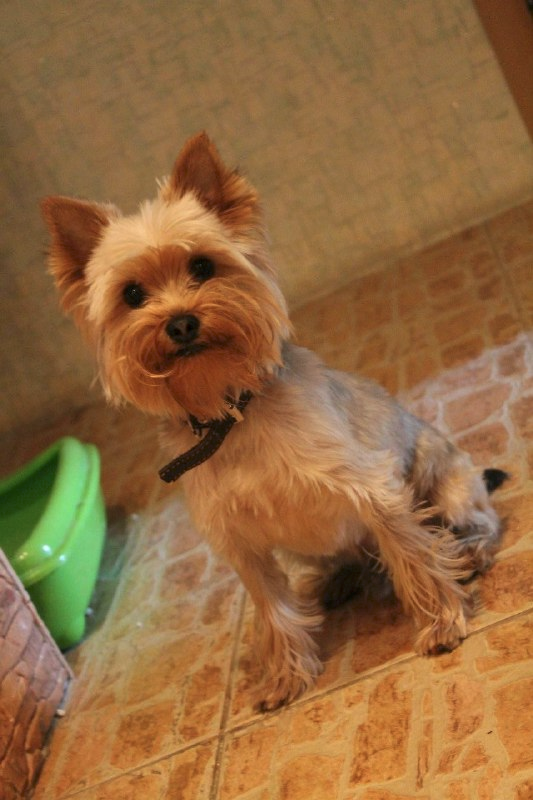

In [21]:
from PIL import Image
import requests


from transformers import TextStreamer

url = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/ec58503b-85ea-4b91-95f4-535ada85346f"
image = Image.open(requests.get(url, stream=True).raw)
prompt = "[INST] <image>\nWhat is shown in this image? [/INST]"
streamer = TextStreamer(processor, skip_special_tokens=True, skip_prompt=True)

inputs = processor(prompt, image, return_tensors="pt")
print("Question:\nWhat is shown in this image?")
image

In [22]:
print("Answer:")
streamer = TextStreamer(processor, skip_special_tokens=True, skip_prompt=True)
output = ov_llava_model.generate(**inputs, max_new_tokens=22, streamer=streamer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Answer:
The image shows a small dog with a fluffy coat, likely a breed such as a Yorkshire Terrier


## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import gradio as gr
from transformers import TextIteratorStreamer
from threading import Thread
from PIL import Image
import torch

example_image_urls = [("https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/1d6a0188-5613-418d-a1fd-4560aae1d907", "bee.jpg"), ("https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/6cc7feeb-0721-4b5d-8791-2576ed9d2863", "baklava.png")]
for (url, file_name) in example_image_urls:
    Image.open(requests.get(url, stream=True).raw).save(file_name)


def bot_streaming(message, history):
    print(message)
    if message["files"]:
        image = message["files"][-1]["path"]
    else:
        # if there's no image uploaded for this turn, look for images in the past turns
        # kept inside tuples, take the last one
        for hist in history:
            if isinstance(hist[0], tuple):
                image = hist[0][0]

    if image is None:
        gr.Error("You need to upload an image for LLaVA to work.")
    prompt = f"[INST] <image>\n{message['text']} [/INST]"
    image = Image.open(image).convert("RGB")
    inputs = processor(prompt, image, return_tensors="pt")

    streamer = TextIteratorStreamer(processor, **{"skip_special_tokens": True})
    generation_kwargs = dict(inputs, streamer=streamer, max_new_tokens=100)

    thread = Thread(target=ov_llava_model.generate, kwargs=generation_kwargs)
    thread.start()

    text_prompt = f"[INST]  \n{message['text']} [/INST]"

    buffer = ""
    for new_text in streamer:
        buffer += new_text
        generated_text_without_prompt = buffer[len(text_prompt) :]
        yield generated_text_without_prompt


demo = gr.ChatInterface(
    fn=bot_streaming,
    title="LLaVA NeXT", examples=[{"text": "What is on the flower?", "files": ["./bee.jpg"]}, {"text": "How to make this pastry?", "files": ["./baklava.png"]}],
    description="Try [LLaVA NeXT](https://huggingface.co/docs/transformers/main/en/model_doc/llava_next) in this demo using OpenVINO. Upload an image and start chatting about it, or simply try one of the examples below. If you don't upload an image, you will receive an error.",
    stop_btn="Stop Generation",
    multimodal=True,
)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)